In [1]:
import os
from functools import partial
import json
import csv

import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import networkx as nx
import pandas as pd
import numpy as np
from tqdm import tqdm_notebook
import random
import seaborn as sns

from gerrychain import (
    Election,
    Graph,
    MarkovChain,
    Partition,
    accept,
    constraints,
    updaters,
)

from gerrychain.metrics import efficiency_gap, mean_median, partisan_gini
from gerrychain.proposals import recom
from gerrychain.updaters import cut_edges
from gerrychain.tree import recursive_tree_part

In [15]:
texas_data = pd.read_csv("./Outputs/tx44000.csv")

In [16]:
utah_data = pd.read_csv("./Outputs/ut17000.csv")

In [17]:
nc_data = pd.read_csv("./Outputs/nc52000.csv")

In [22]:
tx_data12 = pd.read_csv("./Outputs/SEN12_tx_data10000.csv")
tx_data14 = pd.read_csv("./Outputs/SEN14_tx_data7000.csv")

In [39]:
tx_data12.reindex(tx_data12["mm"].abs().sort_values().index)

,seats,mm,pg,vs
3919,27,0.000009,0.037393,"(0.5027430051875332, 0.6796290559101142, 0.361..."
3920,27,0.000014,0.036993,"(0.5027430051875332, 0.6796290559101142, 0.361..."
992,26,0.000017,0.020949,"(0.6787793047696039, 0.5288380069619543, 0.516..."
991,26,0.000025,0.020965,"(0.6787793047696039, 0.5288380069619543, 0.516..."
8981,28,0.000071,0.042479,"(0.34682995164715985, 0.558748712979226, 0.624..."
8980,28,0.000107,0.042553,"(0.34682995164715985, 0.558748712979226, 0.624..."
1729,26,0.000110,0.035041,"(0.5495170906376892, 0.42849897294144496, 0.53..."
1730,26,0.000113,0.035034,"(0.5495170906376892, 0.42849897294144496, 0.53..."
1733,26,0.000114,0.034827,"(0.5495170906376892, 0.42849897294144496, 0.53..."
1734,26,0.000133,0.034789,"(0.5495170906376892, 0.42849897294144496, 0.53..."


In [21]:
tx_data12.sort_values("mm")

,seats,mm,pg,vs
3989,26,-0.013452,0.033744,"(0.4592467739400476, 0.7062024796645111, 0.501..."
3988,26,-0.013436,0.033774,"(0.454619709345497, 0.7062024796645111, 0.5012..."
3987,26,-0.013398,0.033851,"(0.454619709345497, 0.7062024796645111, 0.5012..."
3982,27,-0.013288,0.034871,"(0.5086483393361192, 0.6397711174927351, 0.501..."
3980,27,-0.013245,0.035221,"(0.5086483393361192, 0.6397711174927351, 0.501..."
3981,27,-0.013245,0.035221,"(0.5086483393361192, 0.6397711174927351, 0.501..."
3986,26,-0.012880,0.034946,"(0.454619709345497, 0.7062024796645111, 0.5012..."
3985,26,-0.012539,0.036411,"(0.454619709345497, 0.7062024796645111, 0.5012..."
3983,26,-0.012520,0.036763,"(0.454619709345497, 0.6397711174927351, 0.5012..."
3984,26,-0.012520,0.036763,"(0.454619709345497, 0.6397711174927351, 0.5012..."


In [40]:
def binning_seats(data):
    seats_data = []
    for i in range(len(data)):
        seats_data.append(data["seats"][i])
    return max(seats_data) - min(seats_data) + 1

In [41]:
def make_full_lists(data):
    all_seats = []
    all_mms = []
    all_pgs = []
    for i in range(len(data)):
        all_seats.append(data["seats"][i])
        all_mms.append(data["mm"][i])
        all_pgs.append(data["pg"][i])
    return all_seats, all_pgs, all_mms

In [49]:
def make_winnowed_lists(data, inliers, pg_bound, mm_bound):
    mm_routliers = []
    mm_doutliers = []
    pg_routliers = []
    pg_doutliers = []
    vs_routliers = []
    vs_doutliers = []
    ideal_pg_seats = []
    ideal_mm_seats = []

    for i in range(len(data)):
        if data["seats"][i] < inliers[0]:
            mm_doutliers.append(data["mm"][i])
            pg_doutliers.append(data["pg"][i])
            vs_doutliers.append(data["vs"][i])
        if data["seats"][i] > inliers[1]:
            mm_routliers.append(data["mm"][i])
            pg_routliers.append(data["pg"][i])
            vs_routliers.append(data["vs"][i])
        if data["pg"][i] < pg_bound:
            ideal_pg_seats.append(data["seats"][i])
        if abs(data["mm"][i]) < mm_bound:
            ideal_mm_seats.append(data["seats"][i])
            
#         while len(ideal_pg_seats) / len(data) < pg_bound:
#             ideal_pg_seats.append(data.sort_values("pg")["seats"][i])
#         while len(ideal_mm_seats) / len(data) < mm_bound:
#             ideal_mm_seats.append(tx_data12.reindex(tx_data12["mm"].abs().sort_values().index)["seats"][i])

    outlying_mms = [mm_routliers, mm_doutliers]
    outlying_pgs = [pg_routliers, pg_doutliers]

    return outlying_pgs, outlying_mms, len(mm_doutliers) + len(mm_routliers), ideal_pg_seats, ideal_mm_seats

In [50]:
def visualize(state, data, inliers, num_dist, pg_bound, mm_bound):
    
    # Setting up directory for plots
    newdir = "./Outputs/Plots/" + state + "/"
    os.makedirs(os.path.dirname(newdir + "init.txt"), exist_ok=True)
    with open(newdir + "init.txt", "w") as f:
        f.write("Created Folder")    
        
    # Setting up seats figures
    fig, seats = plt.subplots(3,1, figsize=(16,12))
    
    # Spacing of subplots
    plt.subplots_adjust(hspace=0.3)
    
    # Colors
    party_colors = ["red", "blue"]
    neutral = "lightslategrey"
    
    # Variables
    bins_num = 20
    out_bins_num = binning_seats(data)
    num_steps = len(data)
    
    # Formatting data
    all_seats, all_pgs, all_mms = make_full_lists(data)
    outlying_pgs, outlying_mms, num_outliers, ideal_pg_seats, ideal_mm_seats = make_winnowed_lists(data, inliers, pg_bound, mm_bound)
    
    # More Variables
    num_best_pgs = len(ideal_pg_seats)
    num_best_mms = len(ideal_mm_seats)
    pct_outliers = round(num_outliers / num_steps * 100, 1)
    pct_best_pgs = round((num_best_pgs/num_steps) * 100, 1)
    pct_best_mms = round((num_best_mms/num_steps) * 100, 1)
    
    # Legend lines
    custom_lines = [[Line2D([0], [0], color="blue", lw=4),
                    Line2D([0], [0], color=neutral, lw=4),
                    Line2D([0], [0], color="red", lw=4),
                    Line2D([0], [0], color="black", lw=2, linestyle="-")],
                   [Line2D([0], [0], color="lightblue", lw=4),
                    Line2D([0], [0], color=neutral, lw=4),
                    Line2D([0], [0], color="lightcoral", lw=4),
                    Line2D([0], [0], color="black", lw=2, linestyle="-")],
                   [Line2D([0], [0], color="lightblue", lw=4),
                    Line2D([0], [0], color=neutral, lw=4),
                    Line2D([0], [0], color="lightcoral", lw=4),
                    Line2D([0], [0], color="black", lw=2, linestyle="-")]]
    
    outlier_labels = ["Dem. leaning plans", "Neutral plans", "Rep. leaning plans", "50% seats"]
    
    # Titles 
    all_plans_title = state + ": " + str(num_steps) + " ReCom plans"
    outlying_seats_title = state + ": " + str(num_outliers) + " outlier plans " + "(" + str(pct_outliers) + "%)"
    all_seats_title = state + ": Republican seats won: " + str(num_steps) + " ReCom plans" 
    ideal_pgs_title = state + " Republican seats won: " + str(num_best_pgs) + " plans with PG < " + str(pg_bound) + " (" + str(pct_best_pgs) + "% of all plans)"
    ideal_mms_title = state + " Republican seats won: " + str(num_best_mms) + " plans with |MM| < " + str(mm_bound) + " (" + str(pct_best_mms) + "% of all plans)"
    
    seats_titles = [all_seats_title, ideal_pgs_title, ideal_mms_title]
    
    # Plotting the data into the seats figures
    n, bins, patches = seats[0].hist(all_seats, bins=range(num_dist+2), color=neutral)
    for i in range(num_dist):
        if i < inliers[0]:
            patches[i].set_fc("blue")
        if i > inliers[1]:
            patches[i].set_fc("red")
    n, bins, patches = seats[1].hist(ideal_pg_seats, bins=range(num_dist+2), color=neutral)
    for i in range(num_dist):
        if i < inliers[0]:
            patches[i].set_fc("lightblue")
        if i > inliers[1]:
            patches[i].set_fc("lightcoral")
    n, bins, patches = seats[2].hist(ideal_mm_seats, bins=range(num_dist+2), color=neutral)
    for i in range(num_dist):
        if i < inliers[0]:
            patches[i].set_fc("lightblue")
        if i > inliers[1]:
            patches[i].set_fc("lightcoral")
            
    # Aesthetics for seats figures
    for i in range(3):
        seats[i].grid()
        seats[i].set_ylabel("Frequency")
        seats[i].set_xlabel("# Seats Won")
        seats[i].set_xlim(0, num_dist+1)
        seats[i].set_xticks(range(num_dist + 2))
        seats[i].set_xticklabels(range(num_dist + 1))
        seats[i].axvline(x=(num_dist+1)/2, color="black", linewidth=2)
        # NEED TO PUT IN PROPORTIONAL MARKER
        seats[i].set_title(seats_titles[i])
        leg1 = seats[i].legend(custom_lines[i], outlier_labels, loc="best")
        
    # Saving seats figures
    fig.savefig(newdir + "seats_" + str(len(data)) + ".png")

    # 4 figures stuff
    fig, ax = plt.subplots(2,2, figsize=(16,8), sharex="col", sharey="row")
    
    # Spacing of subplots
    plt.subplots_adjust(wspace=0.3, hspace=0.3)
    
    # Plotting the data into the metrics figures
    ax[0,0].hist(all_mms, bins=2*bins_num, color=neutral)
    ax[0,1].hist(all_pgs, bins=2*bins_num, color=neutral)
    ax[1,0].hist(outlying_mms, bins=bins_num, color=party_colors, stacked=False)
    ax[1,1].hist(outlying_pgs, bins=bins_num, color=party_colors, stacked=False)

    # Aesthetics for metrics figures
    for i in [0,1]:
        for j in [0,1]:
            ax[i,j].grid()
            ax[i,j].set_ylabel("Frequency")
            ax[i,j].axvline(x=0, color="black", linewidth=2, linestyle="dashed", label="ideal value")
            ax[i,j].tick_params(labelleft=True, labelbottom=True)
            ax[i,j].legend(loc="best")
            if j == 0:
                ax[i,j].set_xlabel("Mean-Median Score")
#                 ax[i,j].set_xlim(-0.01, 0.07)
            else:
                ax[i,j].set_xlabel("Partisan Gini Score")
#                 ax[i,j].set_xlim(-0.01, 0.08)
            if i == 0:
                ax[i,j].set_title(all_plans_title)
            else:
                ax[i,j].set_title(outlying_seats_title)
                
    # Saving metrics figures
    fig.savefig(newdir + "metrics_" + str(len(data)) + ".png")

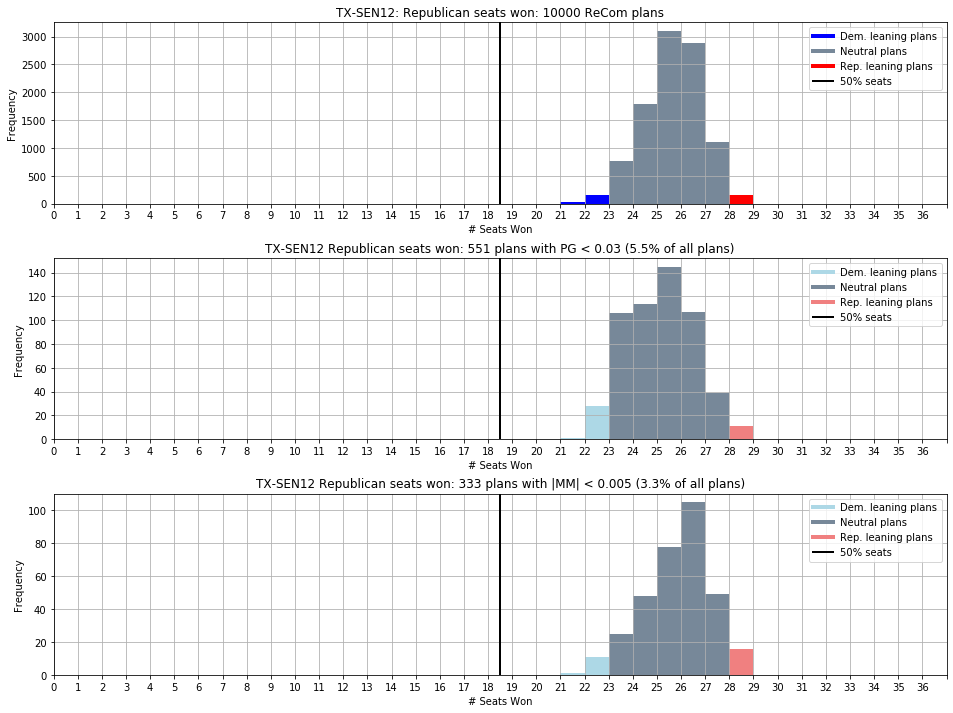

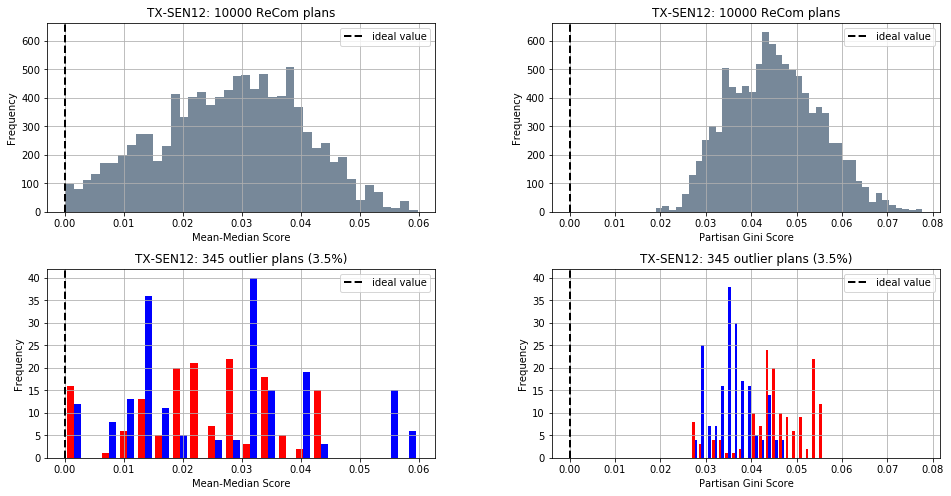

In [52]:
visualize("TX-SEN12", tx_data12, [23, 27], 36, 0.03, 0.005)